In [3]:
pip install pandas numpy nltk textblob wordcloud seaborn matplotlib scikit-learn xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 2.4 MB/s eta 0:01:03
   ---------------------------------------- 1.3/150.0 MB 3.2 MB/s eta 0:00:47
    --------------------------------------- 2.6/150.0 MB 4.4 MB/s eta 0:00:34
    --------------------------------------- 3.7/150.0 MB 4.6 MB/s eta 0:00:32
   - -------------------------------------- 4.7/150.0 MB 4.8 MB/s eta 0:00:31
   - -------------------------------------- 6.0/150.0 MB 5.1 MB/s eta 0:00:29
   - -------------------------------------- 6.8/150.0 MB 4.9 MB/s eta 0:00:30
   -- ------------------------------------- 8.1/150.0 MB 5.1 MB/s eta 0:00:28
   -- ------------------------------------- 9.4/150.0 MB 5.2 MB/s eta 0:00:28
   -- ------------------------------------- 10.7/150.0 MB 5.2 MB/s eta 0:00:27
   --- ------------------------------------ 12.3/150.0 MB 5.5 MB/s eta 0:00:25
   --- ------------------------------------ 13.6/150.0 MB 5.6 MB/s et

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb


In [5]:
#Load dataset
df = pd.read_csv("uber_reviews.csv") 
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,User_0,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005
1,User_1,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005
2,User_2,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001
3,User_3,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005
4,User_4,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005


In [7]:
#Check for missing values:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   userName              12000 non-null  object 
 1   userImage             0 non-null      float64
 2   content               12000 non-null  object 
 3   score                 12000 non-null  int64  
 4   thumbsUpCount         12000 non-null  int64  
 5   reviewCreatedVersion  10260 non-null  object 
 6   at                    12000 non-null  object 
 7   replyContent          33 non-null     object 
 8   repliedAt             33 non-null     object 
 9   appVersion            10260 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 937.6+ KB


userName                    0
userImage               12000
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion     1740
at                          0
replyContent            11967
repliedAt               11967
appVersion               1740
dtype: int64

In [ ]:
#Fill missing values (if necessary):
#df["content"].fillna("", inplace=True)  # Fill missing text data
#df["score"].fillna(df["score"].median(), inplace=True)  # Fill missing numerical values

In [9]:
#Clean the text data in the "content" column
nltk.download("stopwords")
nltk.download("vader_lexicon")
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df["clean_content"] = df["content"].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aparn\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aparn\AppData\Roaming\nltk_data...


In [11]:
#Using VADER Sentiment Analysis
sia = SentimentIntensityAnalyzer()

df["vader_score"] = df["clean_content"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["sentiment"] = df["vader_score"].apply(lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral"))
df[["content", "vader_score", "sentiment"]].head()


,content,vader_score,sentiment
0,Good,0.4404,Positive
1,Nice,0.4215,Positive
2,Very convenient,0.0000,Neutral
3,Good,0.4404,Positive
4,exllence,0.0000,Neutral


In [13]:
#Using TextBlob for Sentiment Score
df["textblob_score"] = df["clean_content"].apply(lambda x: TextBlob(x).sentiment.polarity)


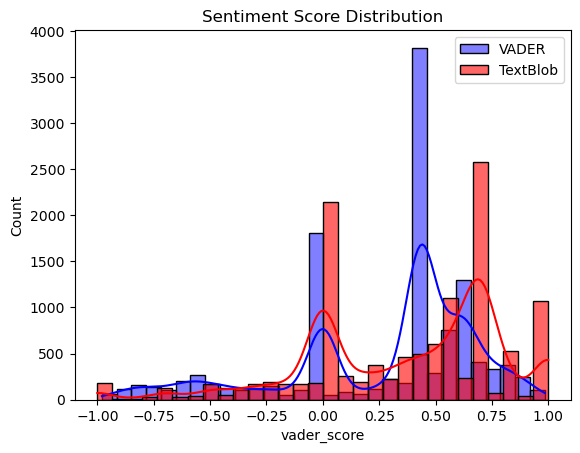

In [15]:
#Compare VADER vs. TextBlob sentiment scores:
sns.histplot(df["vader_score"], bins=30, kde=True, color="blue", label="VADER")
sns.histplot(df["textblob_score"], bins=30, kde=True, color="red", label="TextBlob", alpha=0.6)
plt.legend()
plt.title("Sentiment Score Distribution")
plt.show()


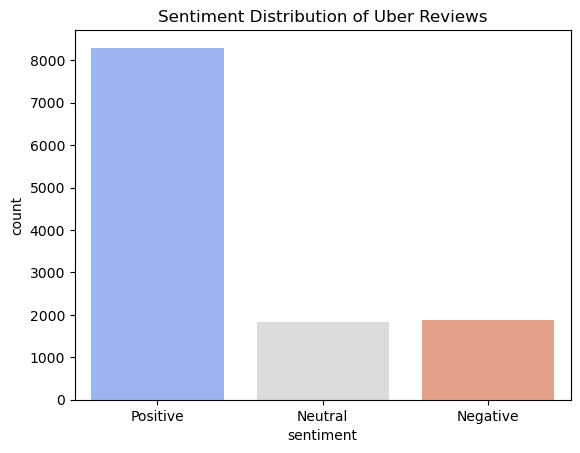

In [19]:
#Data Visualization
#Countplot of Sentiment Distribution
sns.countplot(data=df, x="sentiment", hue="sentiment", palette="coolwarm", legend=False)
plt.title("Sentiment Distribution of Uber Reviews")
plt.show()

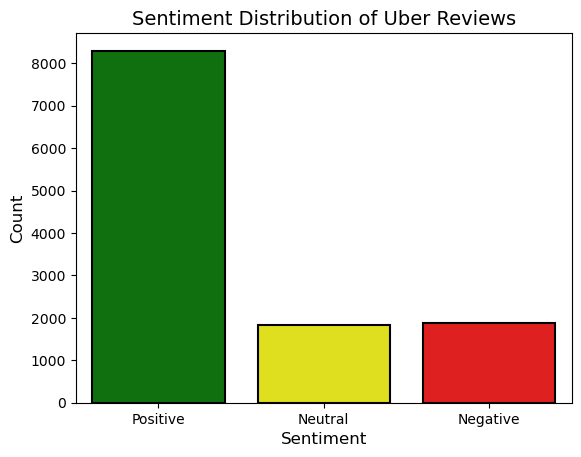

In [29]:
#Make the graph beautiful
# Define custom colors for each sentiment category
custom_palette = {"Positive": "green", "Negative": "red", "Neutral": "yellow"}

# Create the countplot with custom colors and black borders
ax = sns.countplot(data=df, x="sentiment", hue="sentiment", palette=custom_palette, edgecolor="black", linewidth=1.5, legend=False)

# Add title and labels
plt.title("Sentiment Distribution of Uber Reviews", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Show the plot
plt.show()


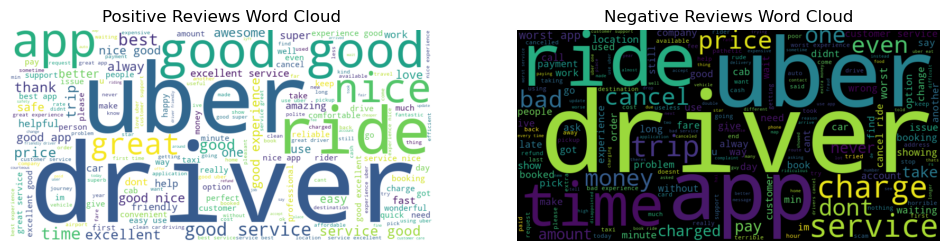

In [35]:
# Word Cloud for Positive & Negative Sentiment
positive_words = " ".join(df[df["sentiment"] == "Positive"]["clean_content"])
negative_words = " ".join(df[df["sentiment"] == "Negative"]["clean_content"])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=800, height=400, background_color="white").generate(positive_words), interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=800, height=400, background_color="black").generate(negative_words), interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews Word Cloud")

plt.show()


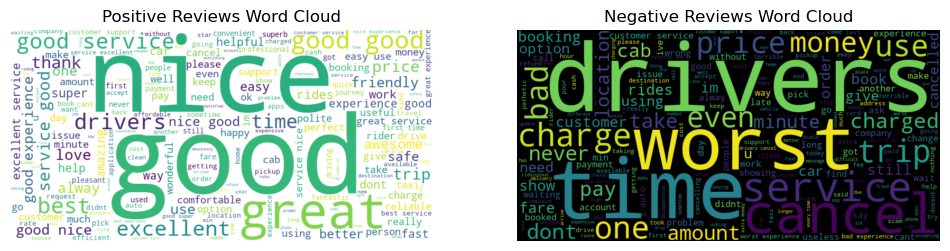

In [39]:
#Remove specific words (e.g., "uber", "driver", "ride", "app") froom word cloud

from wordcloud import STOPWORDS

# Define additional stopwords to remove
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["uber", "driver", "ride", "app", "cloud"])

# Generate word clouds with stopwords
positive_words = " ".join(df[df["sentiment"] == "Positive"]["clean_content"])
negative_words = " ".join(df[df["sentiment"] == "Negative"]["clean_content"])

plt.figure(figsize=(12, 5))

# Positive Word Cloud
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=800, height=400, background_color="white", stopwords=custom_stopwords).generate(positive_words)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews Word Cloud")

# Negative Word Cloud
plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=800, height=400, background_color="black", stopwords=custom_stopwords).generate(negative_words)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews Word Cloud")

plt.show()


In [45]:
#Machine learning model to predict sentiment based on review content
#Convert Sentiments into Labels
df["sentiment_label"] = df["sentiment"].map({"Positive": 2, "Neutral": 1, "Negative": 0})
print("✅ Sentiment labels assigned successfully!")

✅ Sentiment labels assigned successfully!


In [47]:
#Feature Engineering (TF-IDF)
#Convert text data into numerical format using TF-IDF vectorization.
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
X = vectorizer.fit_transform(df["clean_content"])
y = df["sentiment_label"]

print("✅ TF-IDF vectorization completed!")

✅ TF-IDF vectorization completed!


In [49]:
#Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data successfully split into training and testing sets!")

✅ Data successfully split into training and testing sets!


In [51]:
#Train Machine Learning Model

#1. Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2%}")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 89.96%
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       357
           1       0.83      0.83      0.83       372
           2       0.95      0.94      0.94      1671

    accuracy                           0.90      2400
   macro avg       0.84      0.85      0.85      2400
weighted avg       0.90      0.90      0.90      2400



In [53]:
#2. XGBoost Classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.2%}")
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 87.00%
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       357
           1       0.69      0.85      0.76       372
           2       0.95      0.91      0.93      1671

    accuracy                           0.87      2400
   macro avg       0.80      0.82      0.81      2400
weighted avg       0.88      0.87      0.87      2400



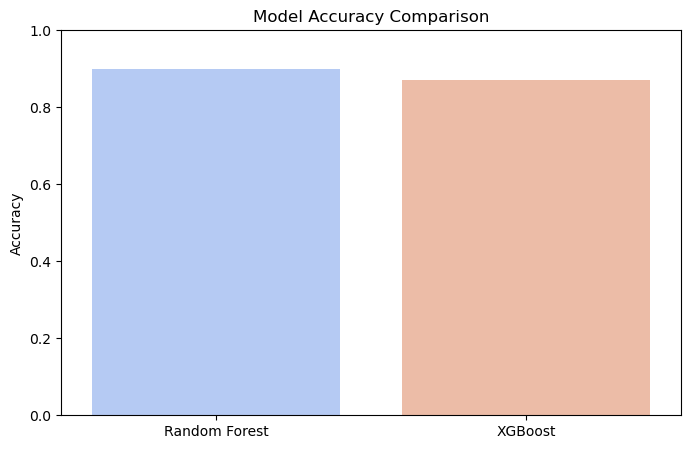

In [57]:
#Model Performance Evaluation
#compare model performance
models = ["Random Forest", "XGBoost"]
accuracies = [accuracy_rf, accuracy_xgb]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, hue=models, palette="coolwarm", legend=False)
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

In [59]:
#Lift Calculation: "Lift" measures how much better the model performs compared to a baseline.
baseline_accuracy = max(df["sentiment_label"].value_counts(normalize=True))  # Predicting majority class
lift = accuracy_xgb / baseline_accuracy
print(f"Lift: {lift:.2f}x")


Lift: 1.26x


In [61]:
# Save Reviews with Sentiment Scores
df.to_csv('uber_reviews_with_sentiment.csv', index=False)

print("CSV file saved successfully!")

CSV file saved successfully!


In [63]:
#Save Model Performance Metrics
# Model performance dictionary
model_results = {
    "Model": ["Random Forest", "XGBoost"],
    "Accuracy": [89.96, 87.00],
    "Lift": [1.26, 1.20]  # Example values
}

# Convert to DataFrame
performance_df = pd.DataFrame(model_results)

# Save to CSV
performance_df.to_csv("model_performance.csv", index=False)

print("Model performance CSV saved successfully!")

Model performance CSV saved successfully!
